In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yfinance as yf
import os

Befor plotting first we will download the S$P 500 file using yfinance module.

In [ ]:
os.makedirs("data", exist_ok=True)

sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-12-31")
sp500.reset_index(inplace=True)
sp500.to_csv("data/sp500.csv", index=False)
print("\nFile downloaded")


C:\Users\surji\AppData\Local\Temp\ipykernel_15052\1273803903.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


File downloaded


In [ ]:
rolling_analysis_path = r"C:\Users\surji\Desktop\Quant_Poject\Perfomance_metrics\data\pe_ratio_rolling_analysis.csv"
df = pd.read_csv(rolling_analysis_path, parse_dates=['Date'])

sp500_path = r"C:\Users\surji\Desktop\Quant_Poject\Perfomance_metrics\PE Analysis\data\sp500.csv" 
sp500 = pd.read_csv(sp500_path, parse_dates=['Date'])

sp500['Close'] = pd.to_numeric(sp500['Close'], errors='coerce')
sp500 = sp500.dropna(subset=['Close'])

sp500 = sp500.sort_values('Date').reset_index(drop=True)
sp500['Return'] = sp500['Close'].pct_change().fillna(0)
sp500['Cumulative'] = (1 + sp500['Return']).cumprod()
initial_capital = 100000
sp500['SP500_Curve'] = initial_capital * sp500['Cumulative']

tickers = df['TickerName'].unique()
rolling_windows = df['RollingWindow'].unique()


Plotting of the multiple y axis plot

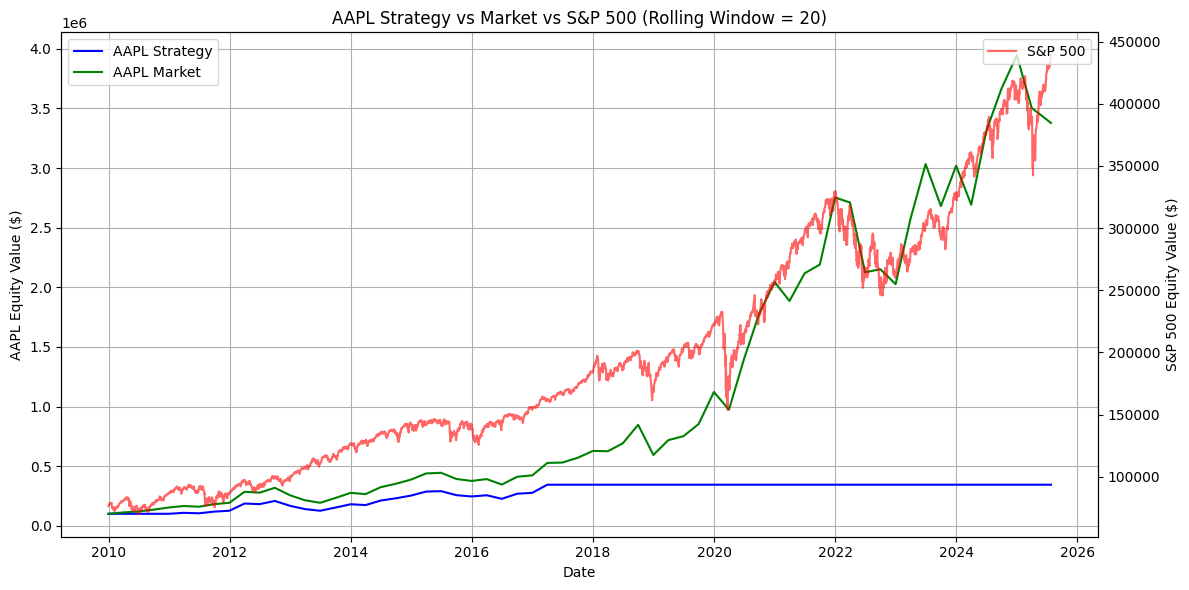

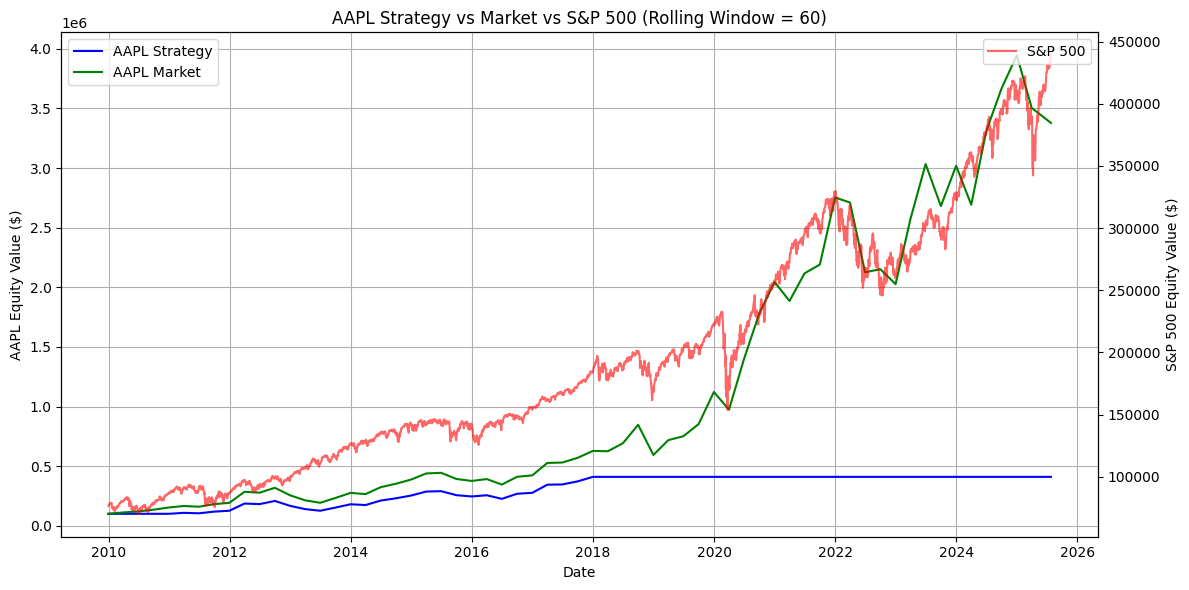

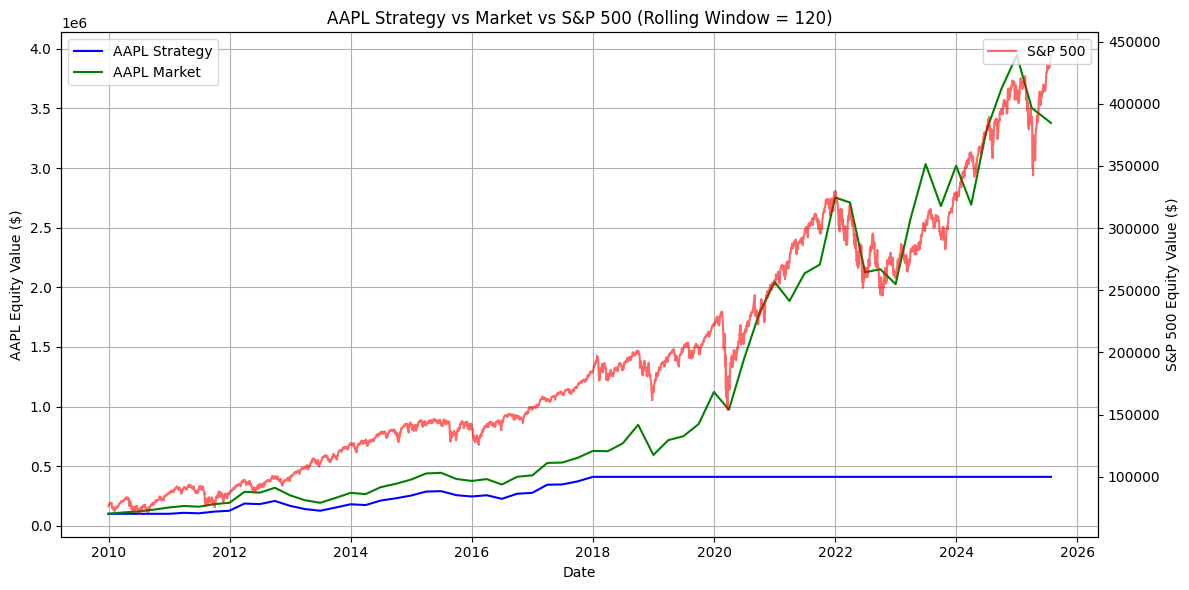

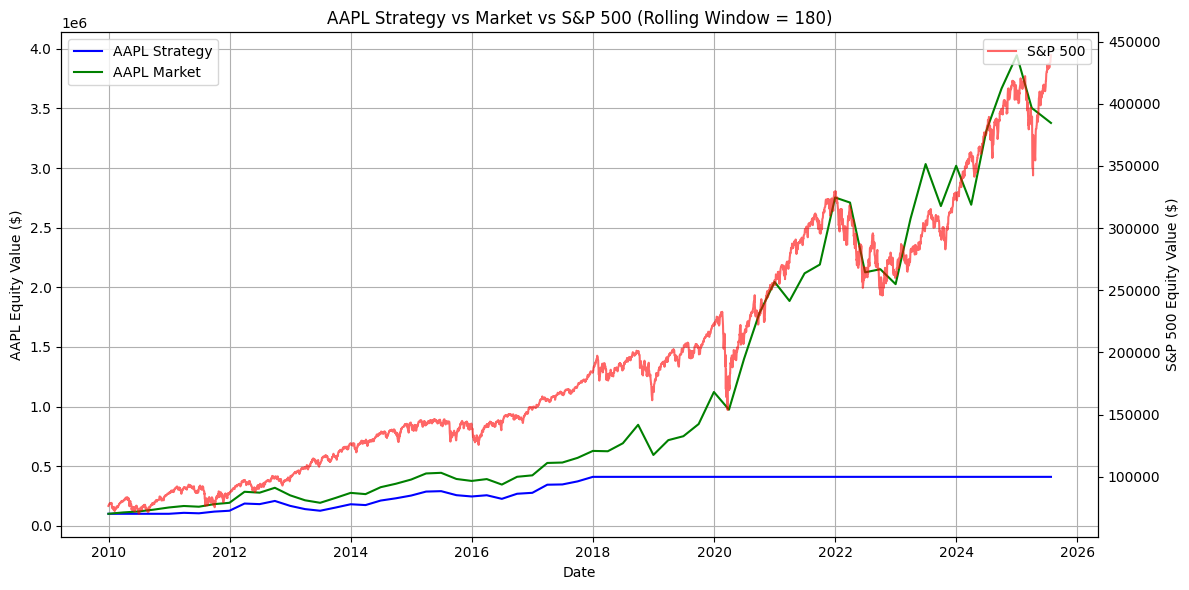

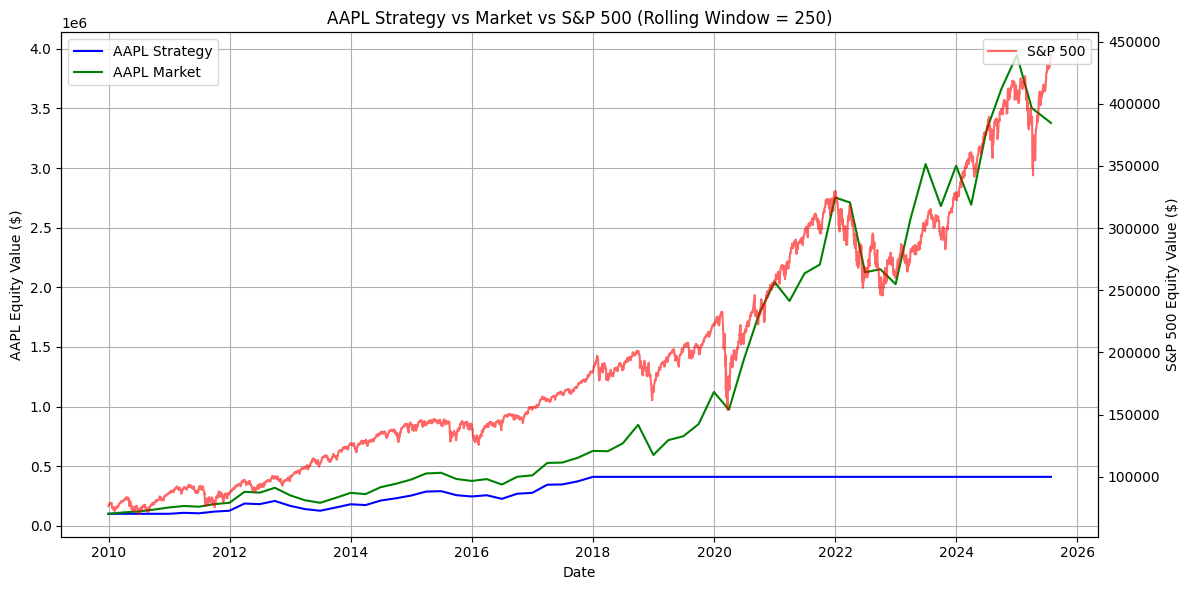

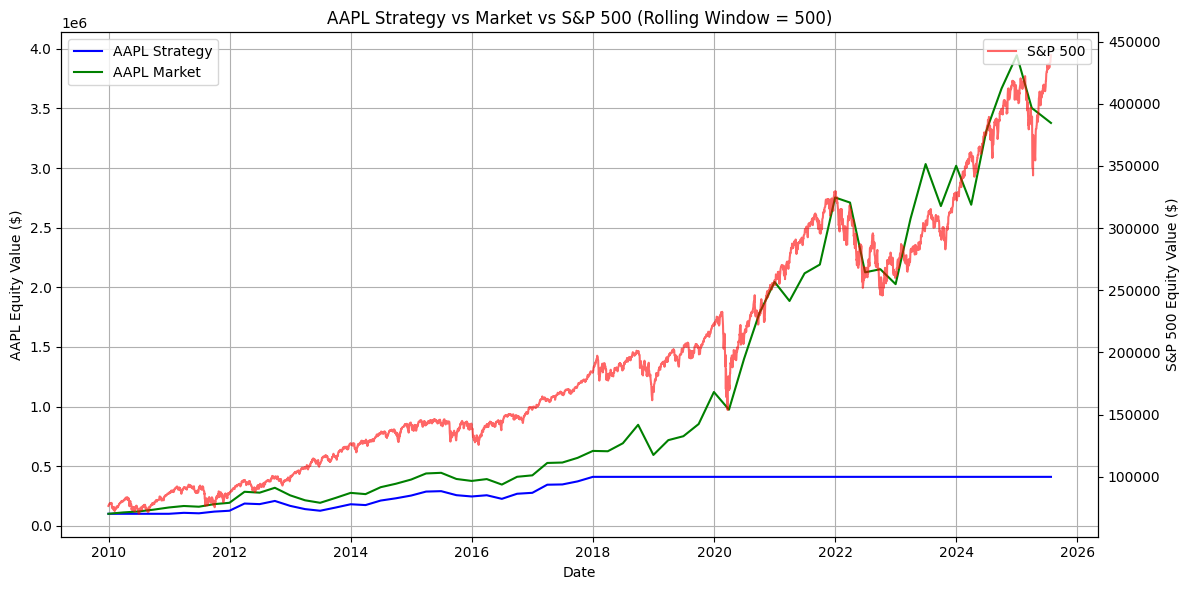

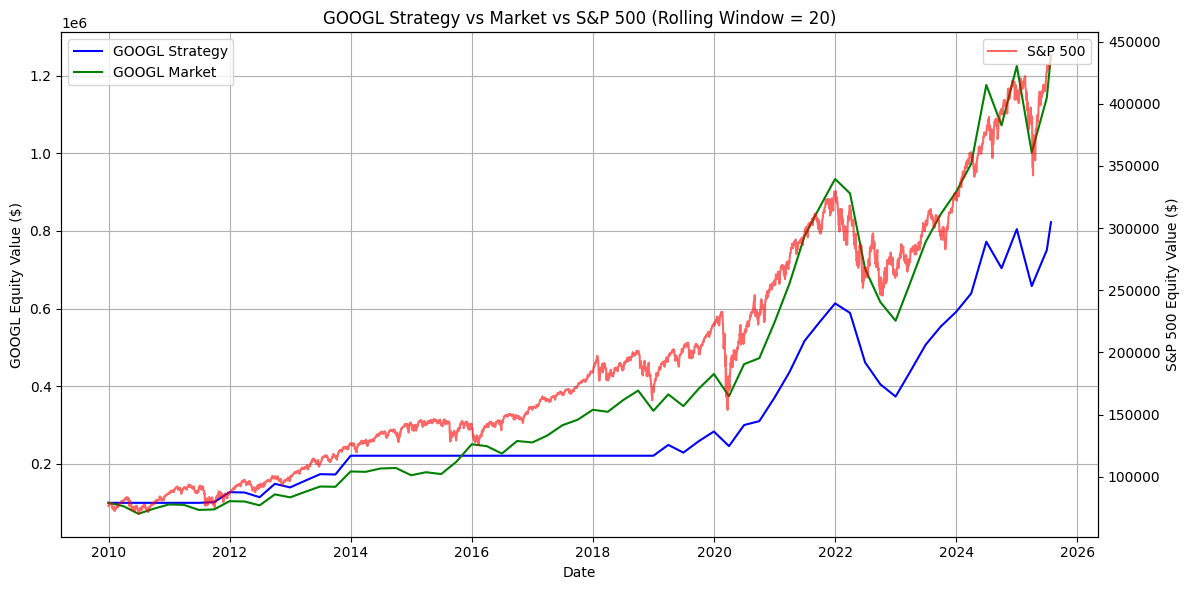

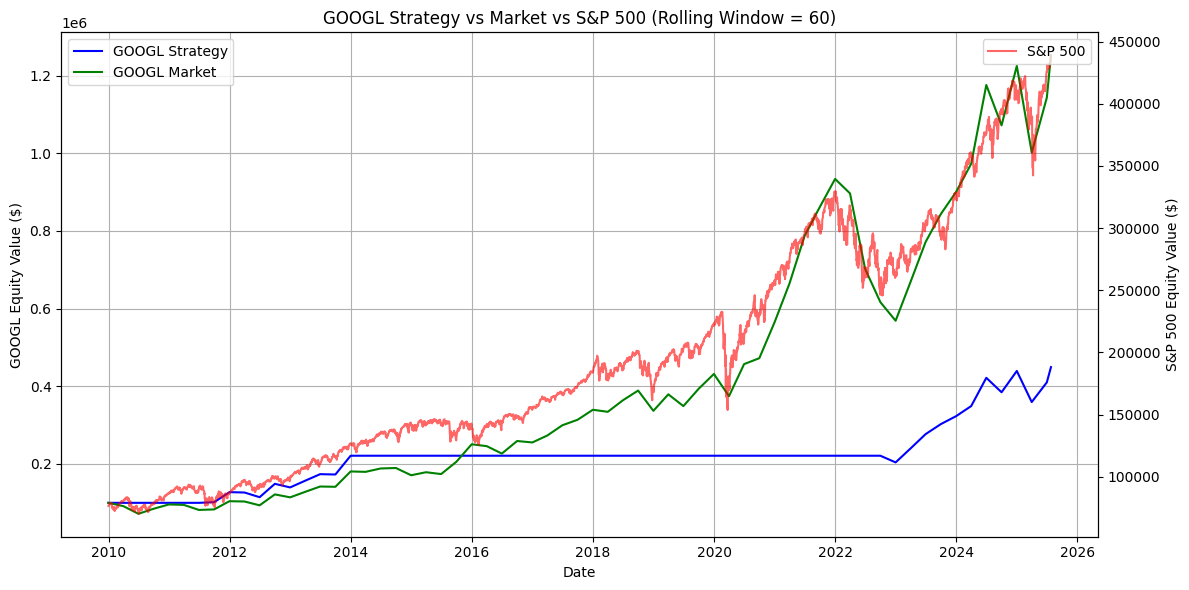

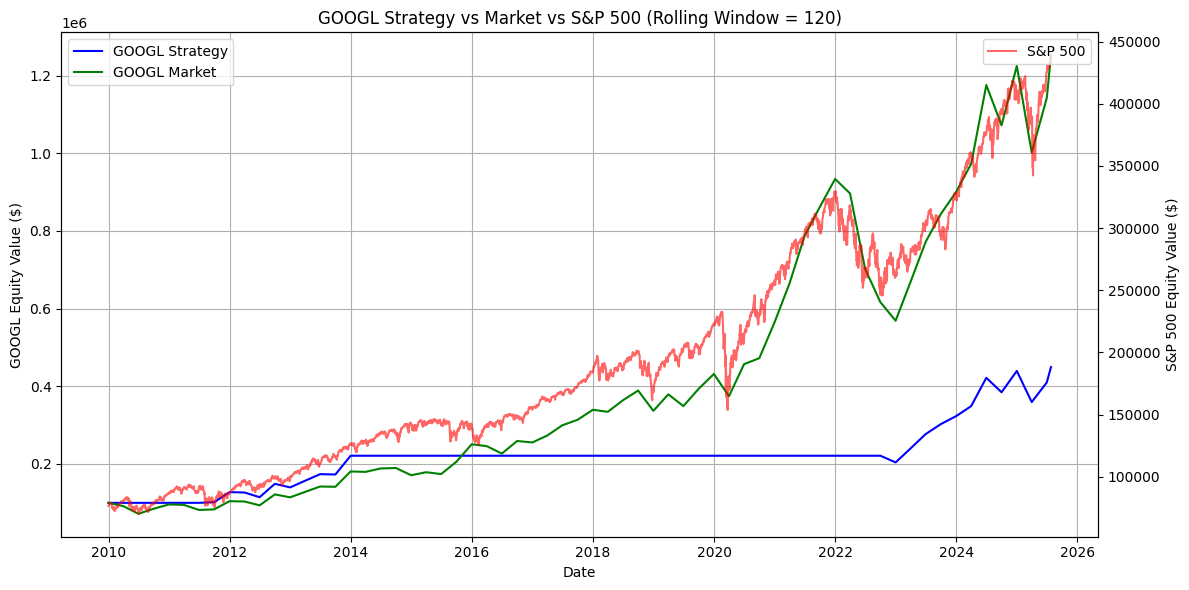

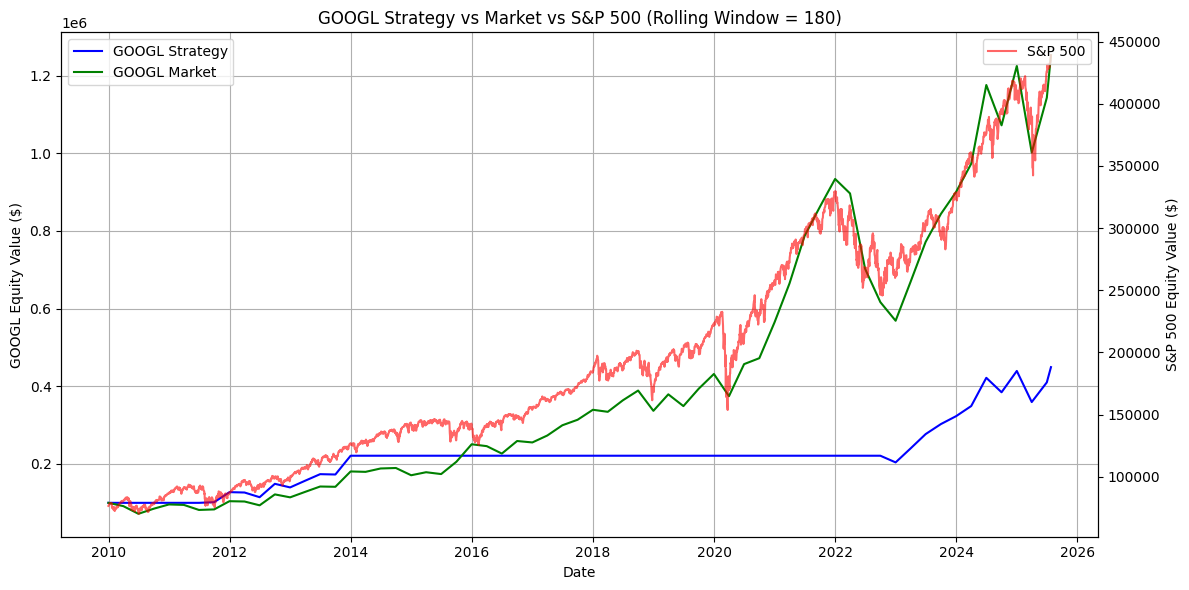

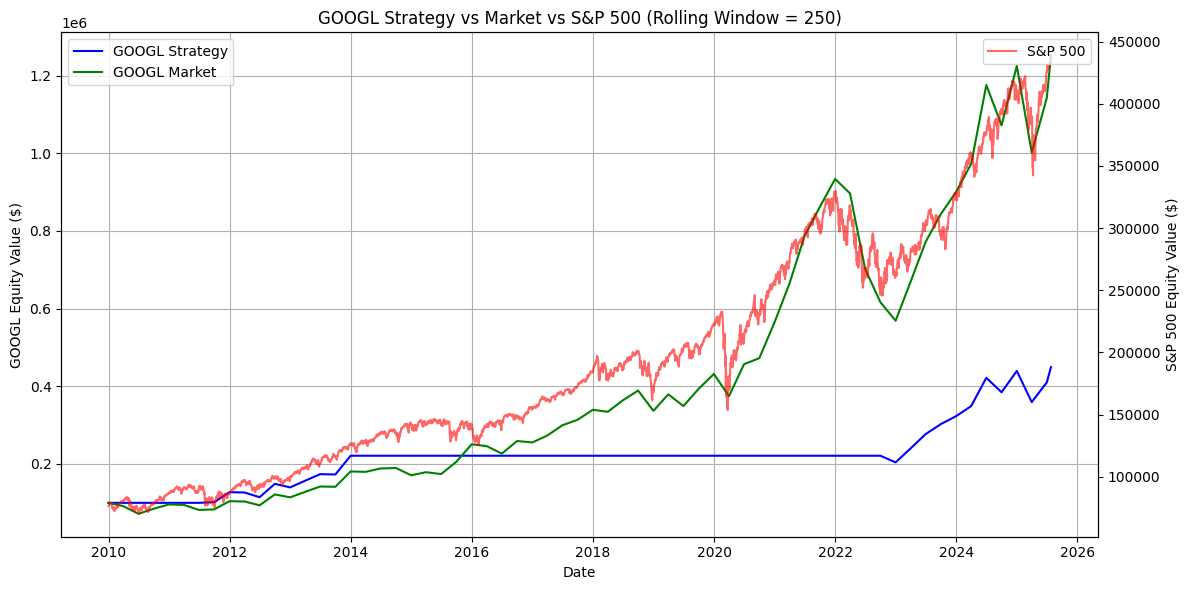

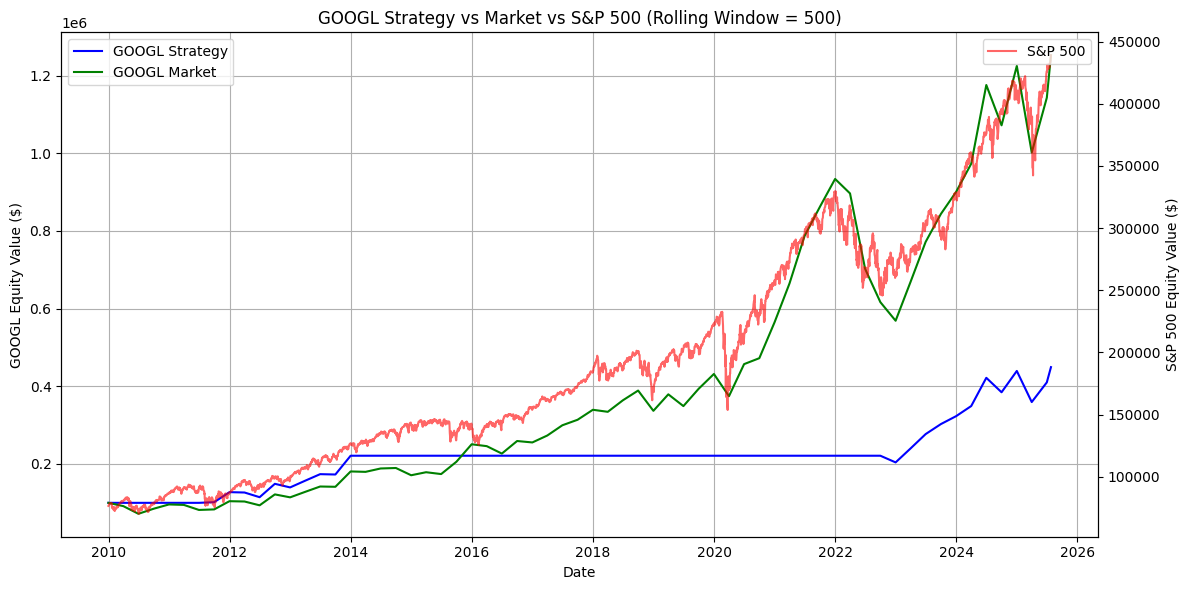

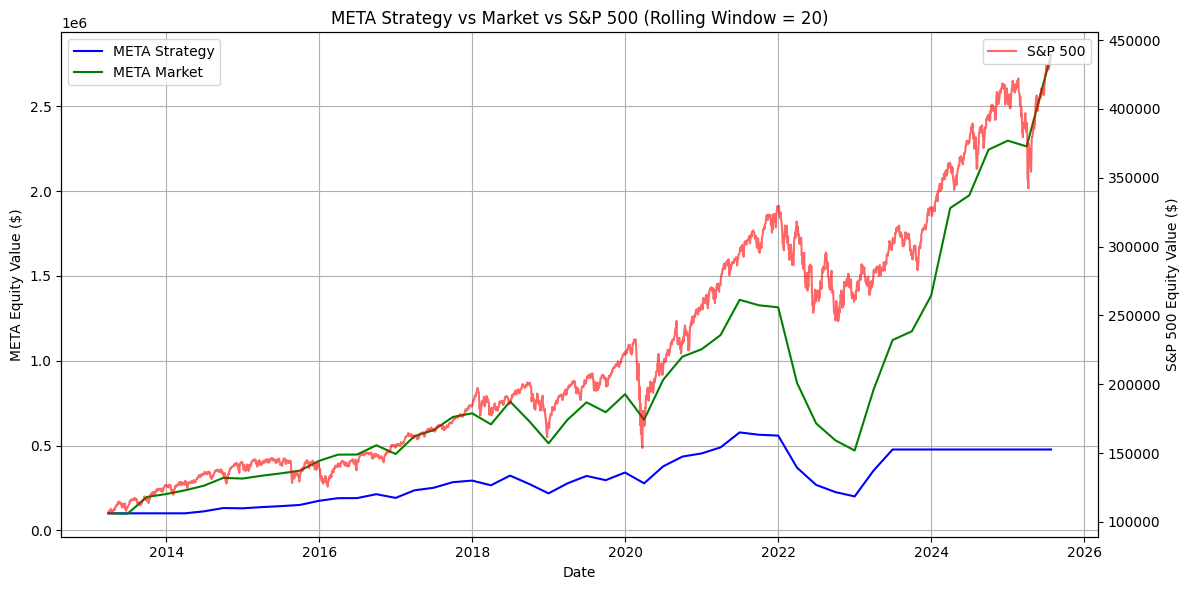

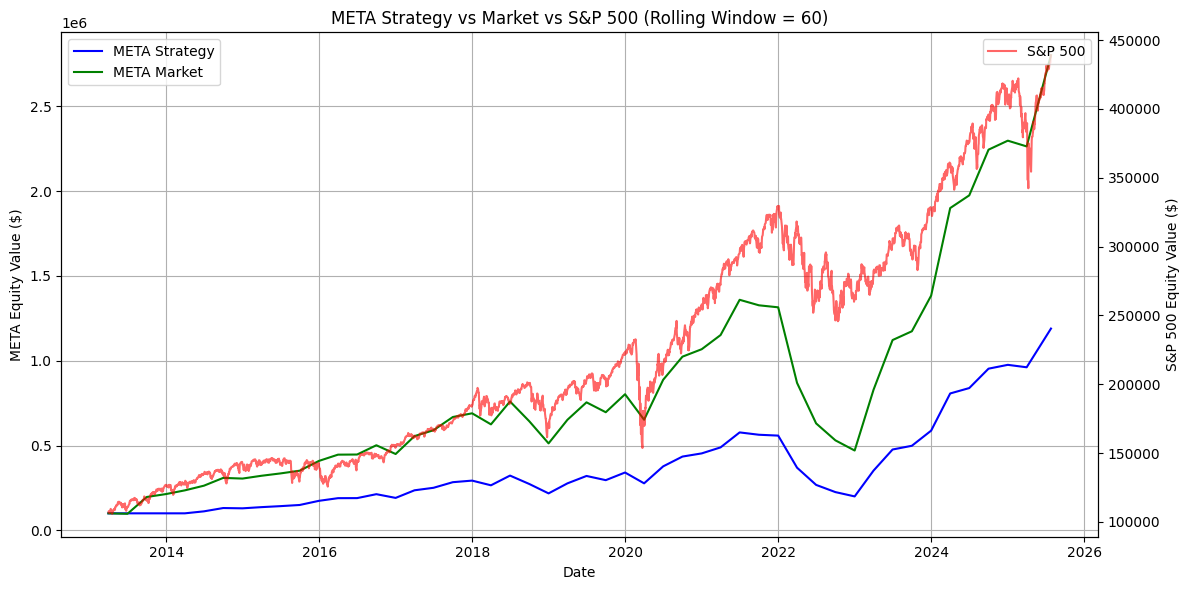

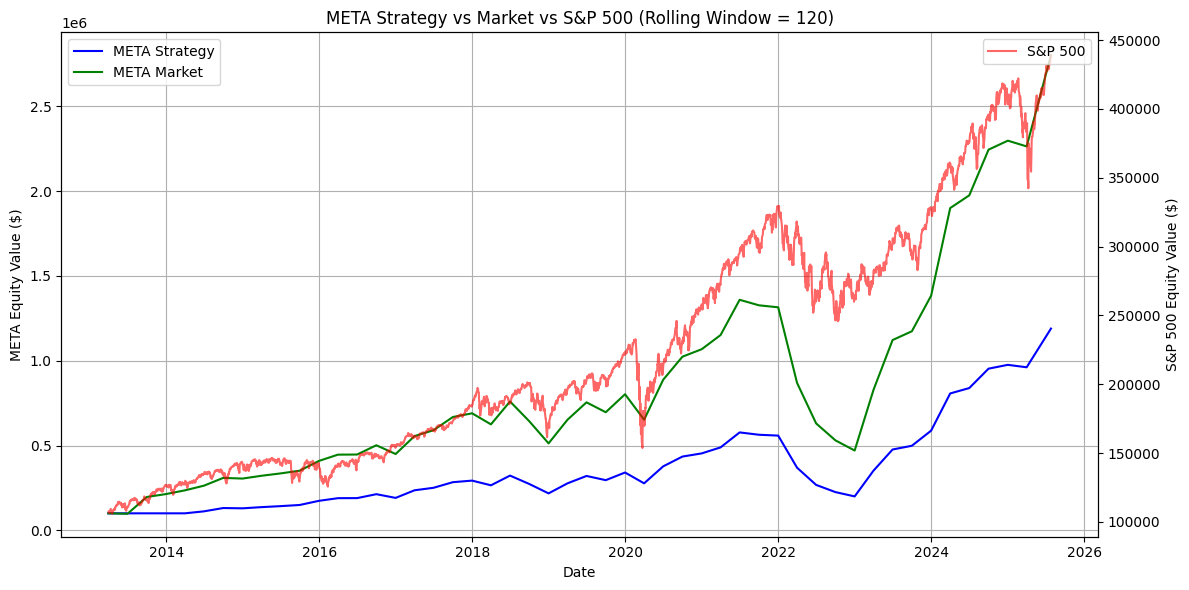

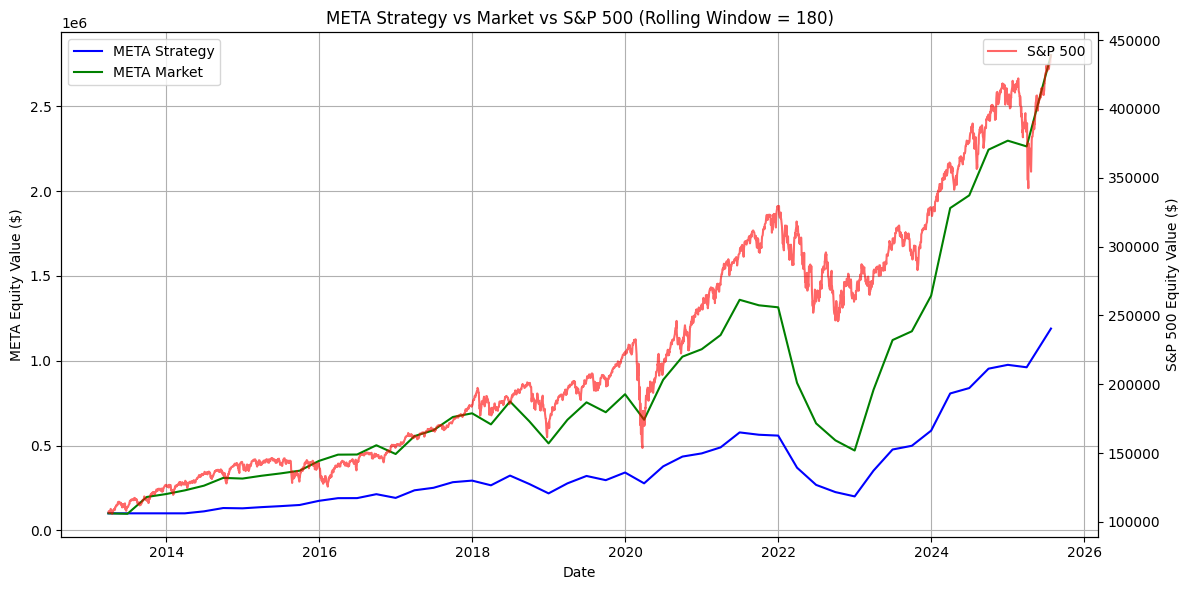

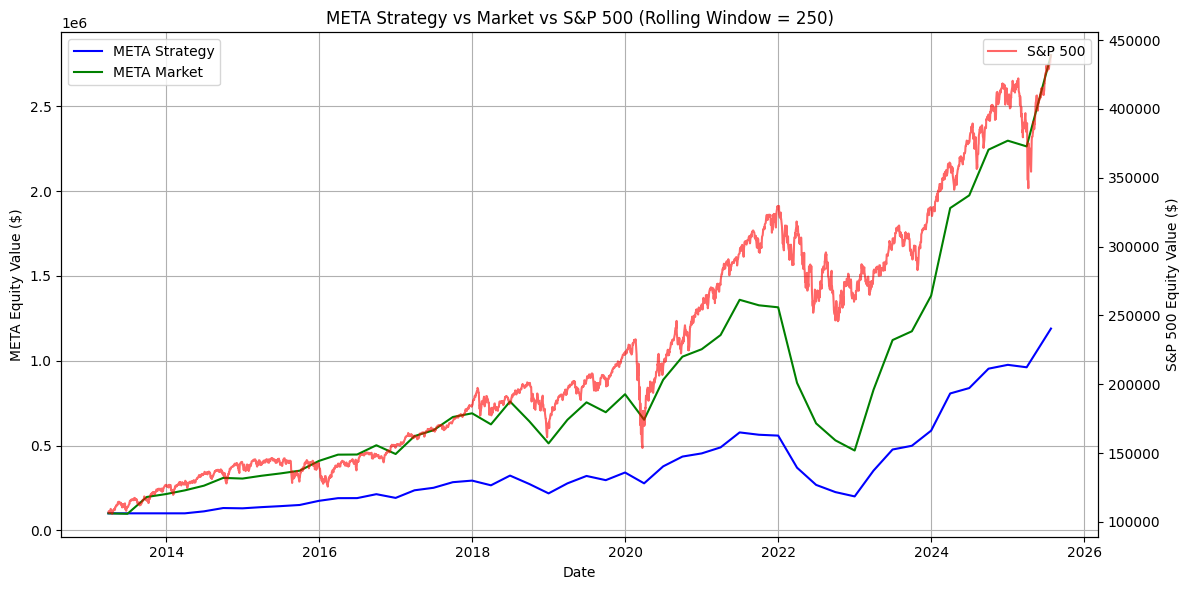

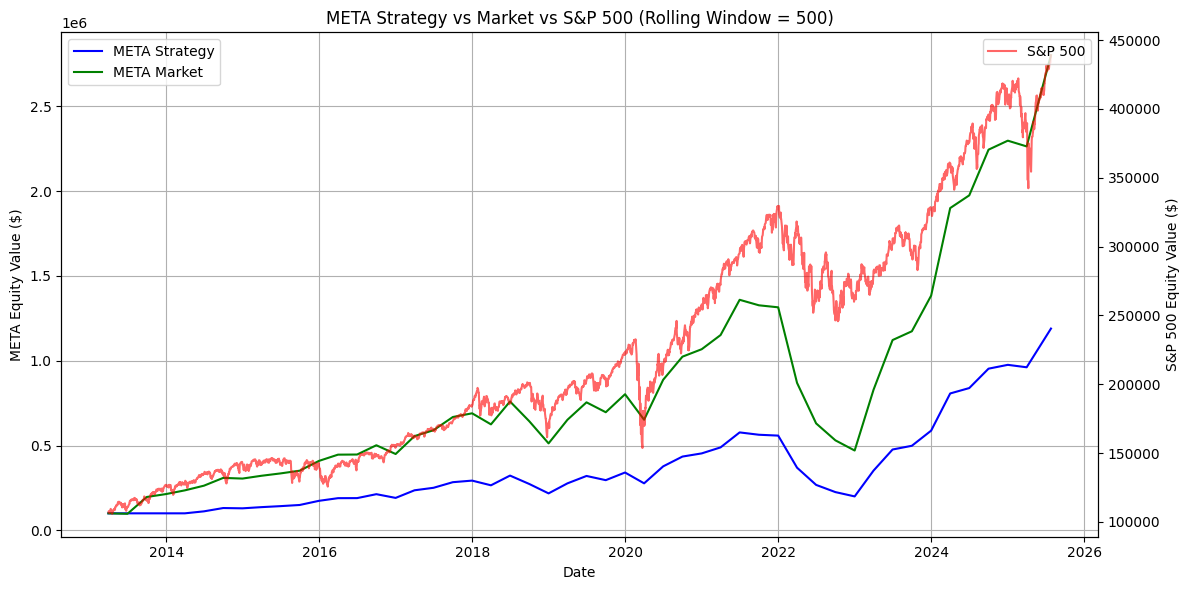

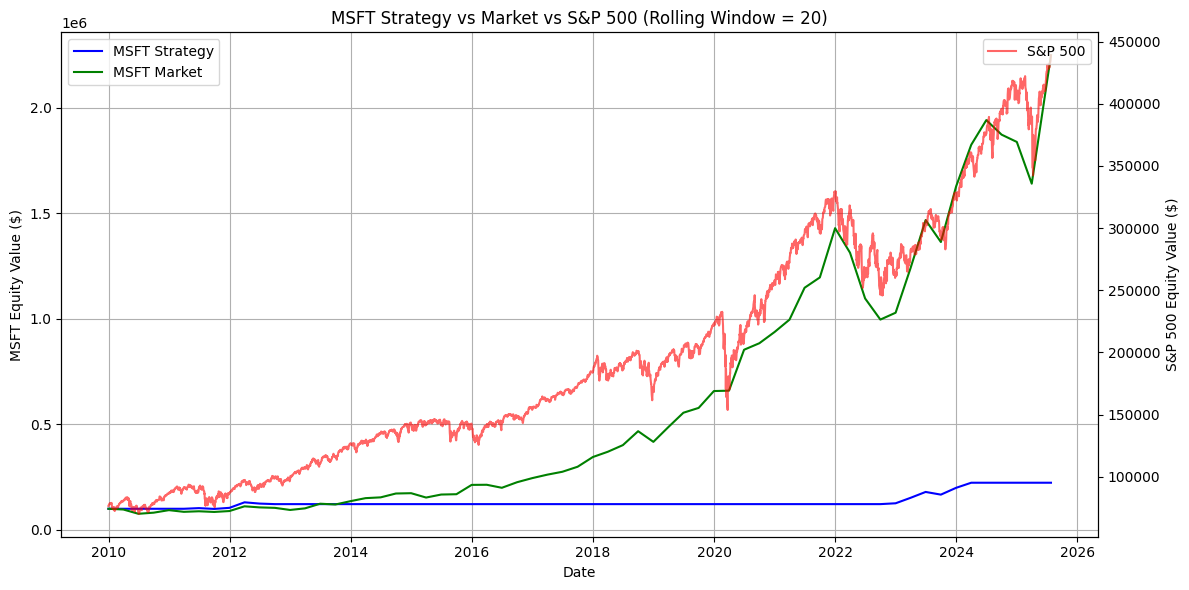

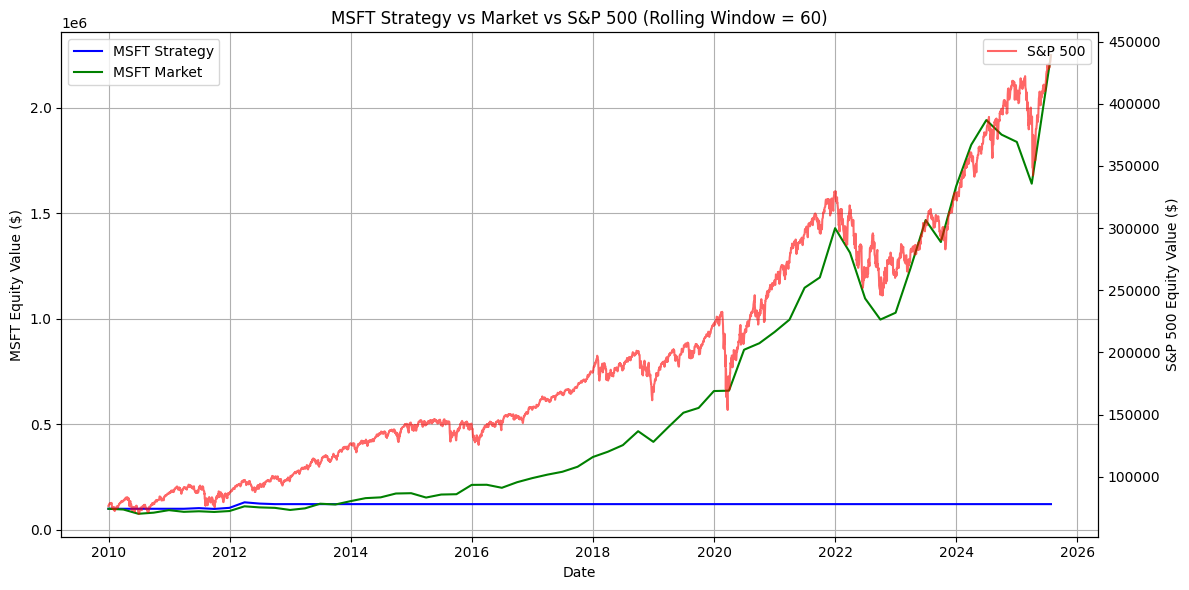

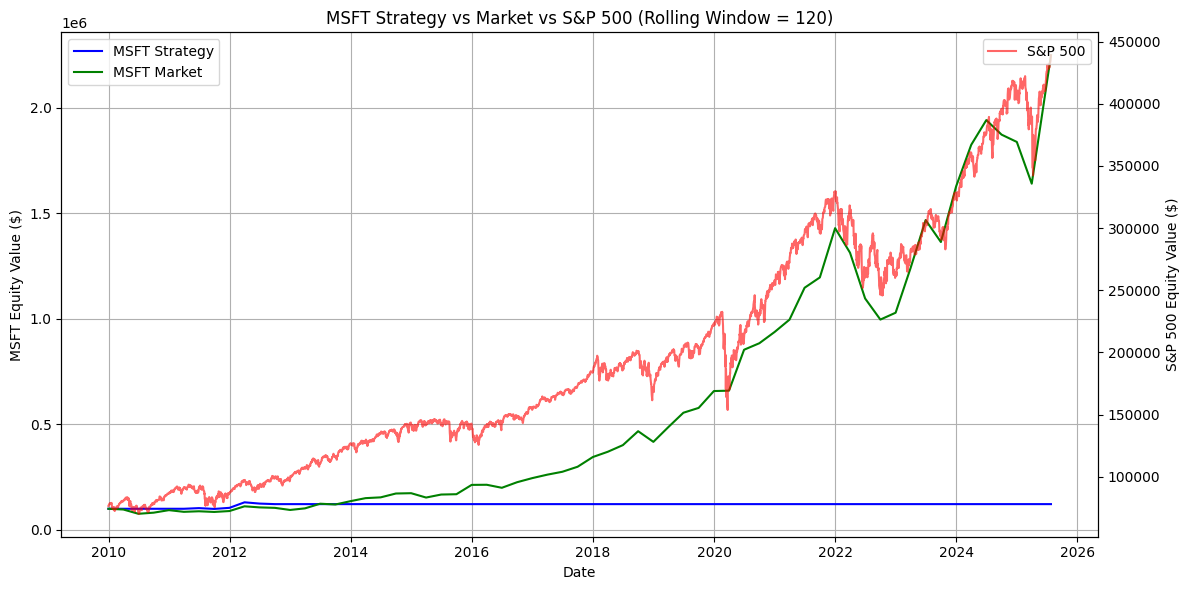

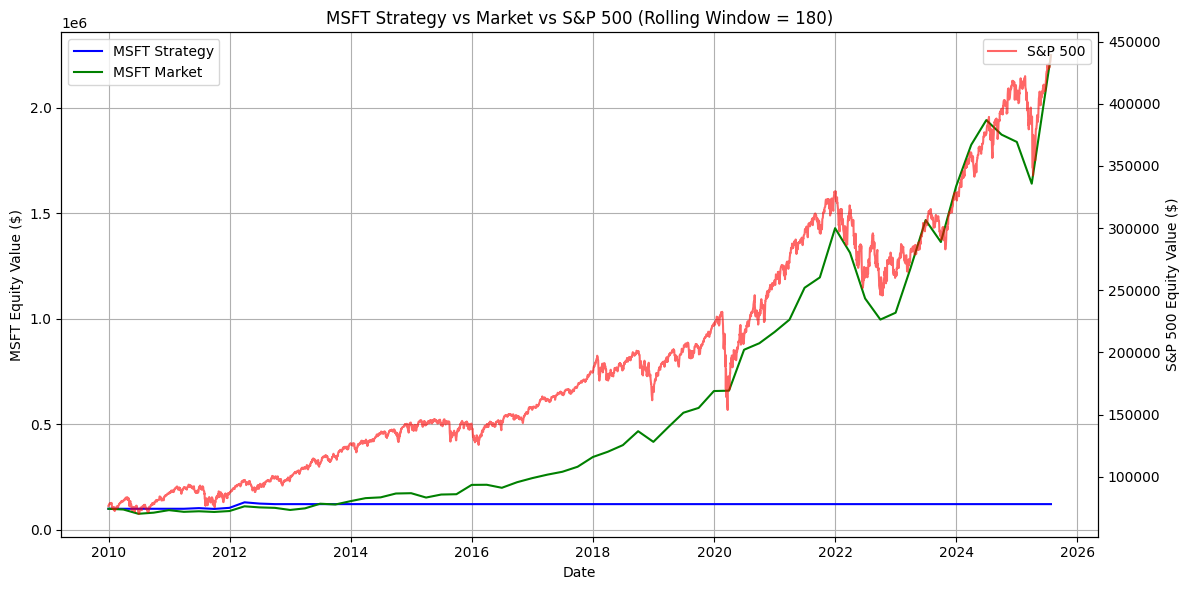

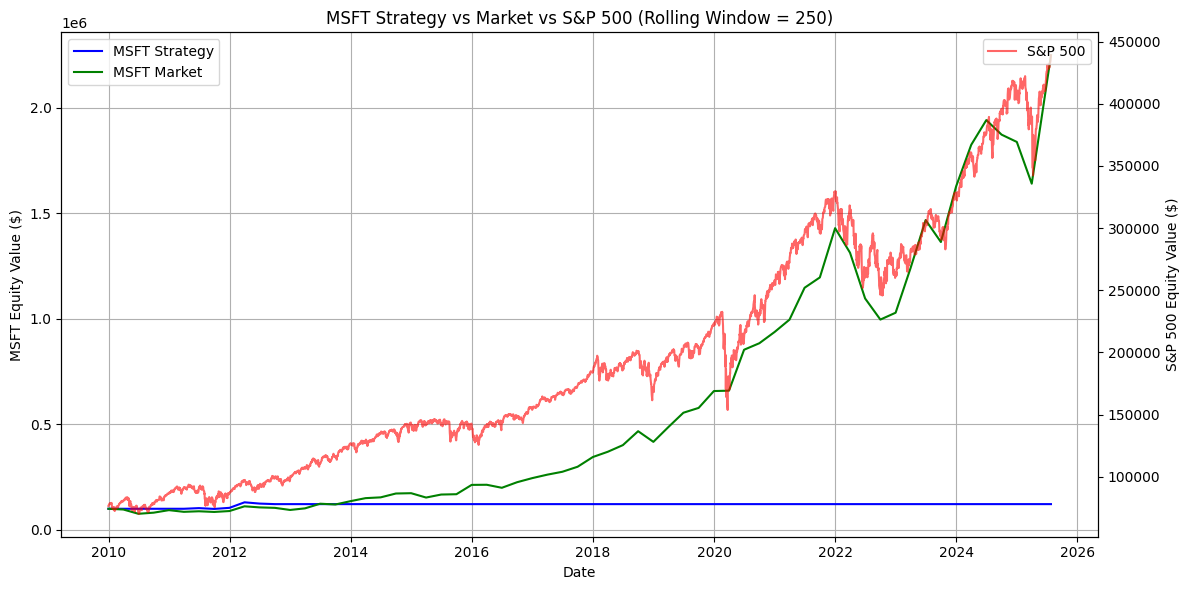

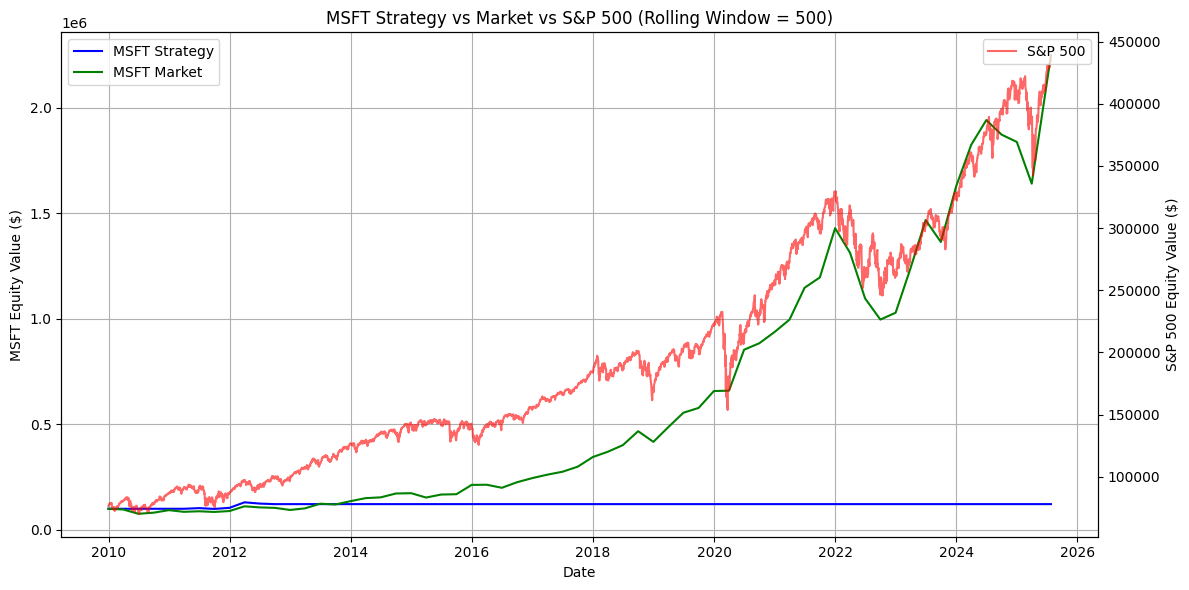

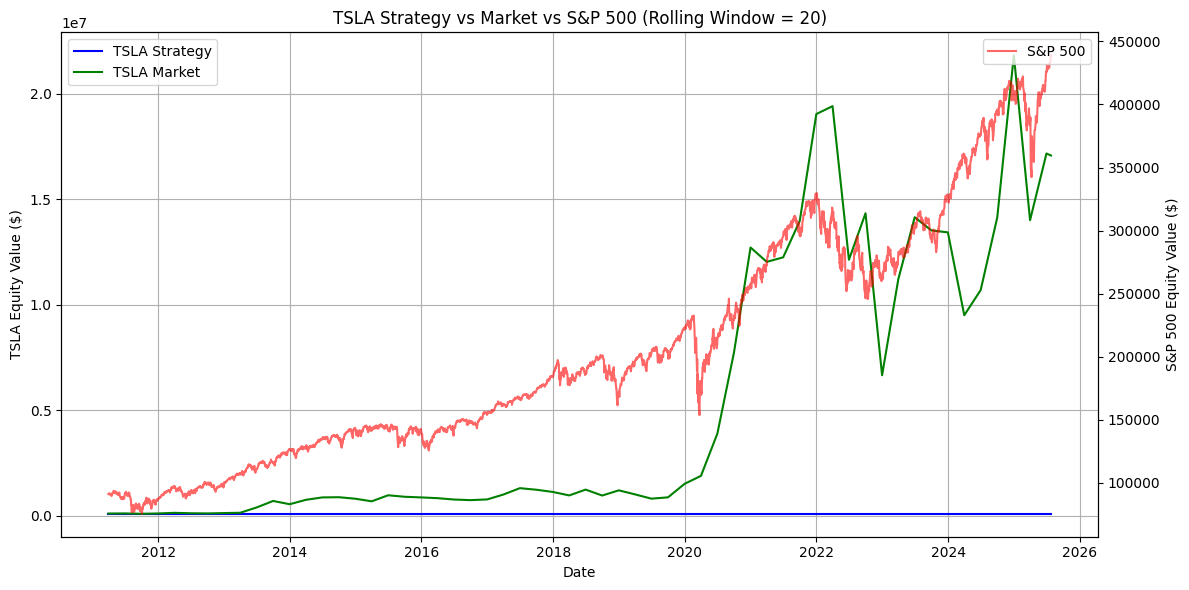

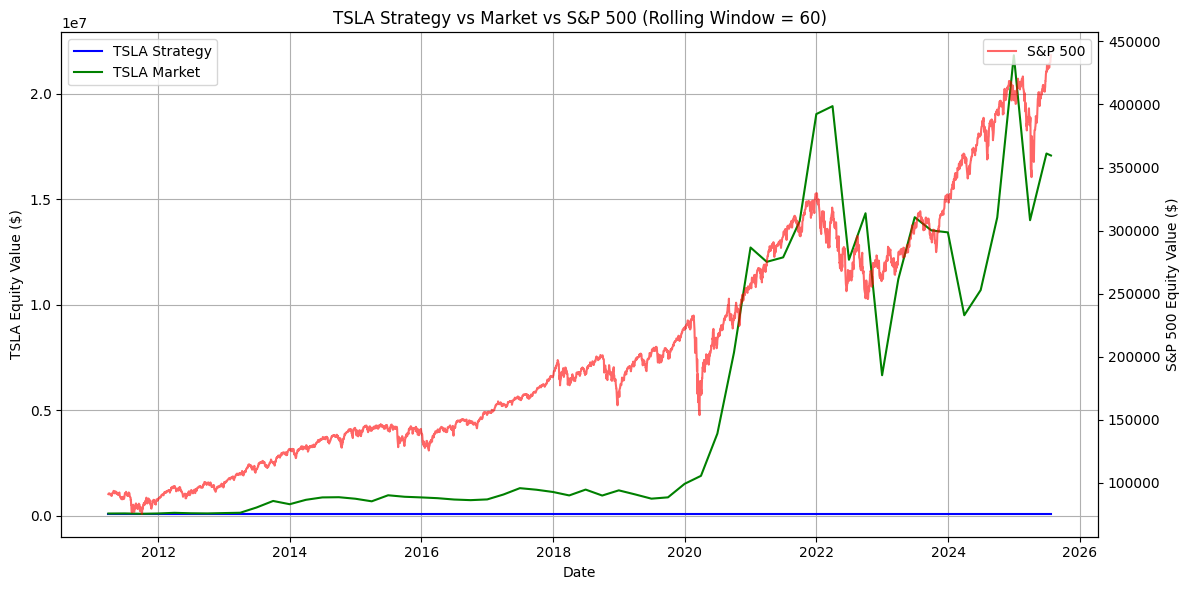

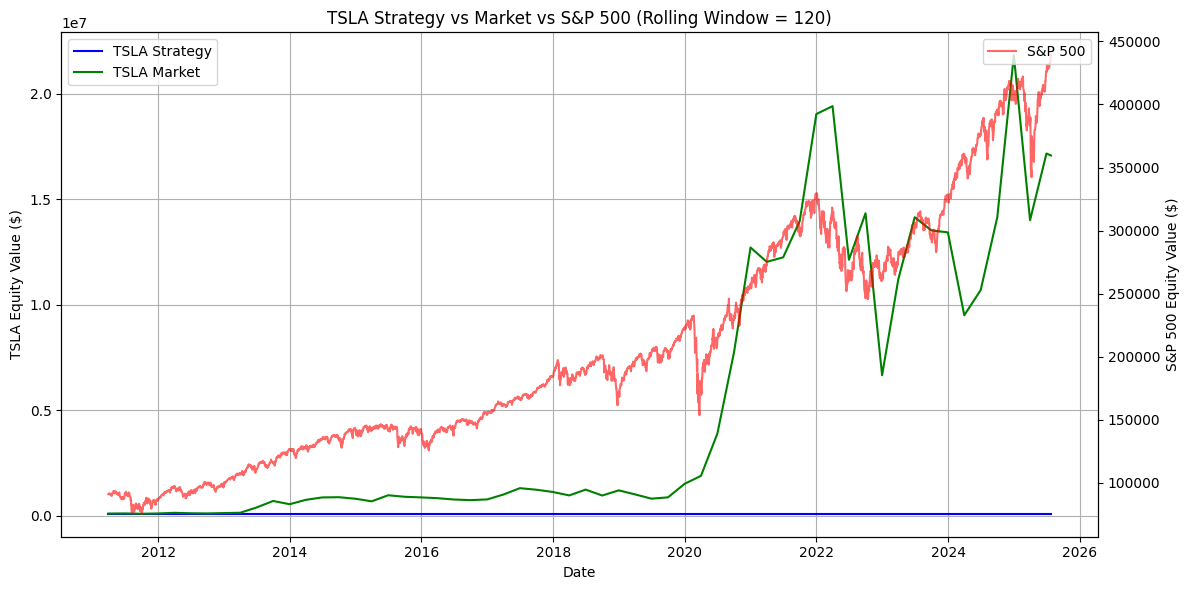

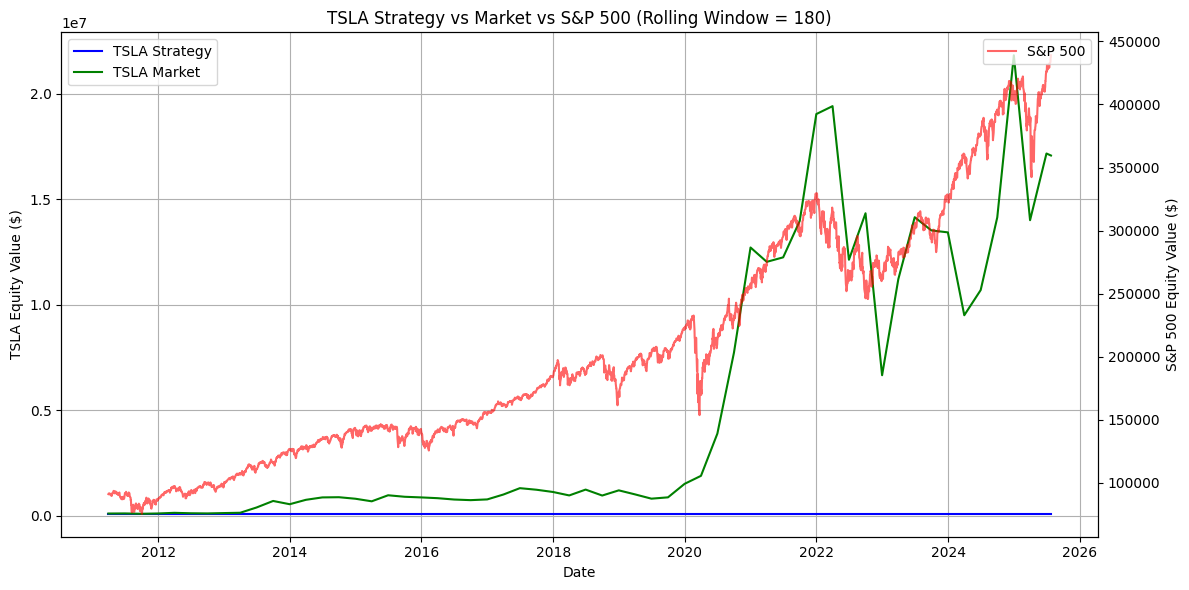

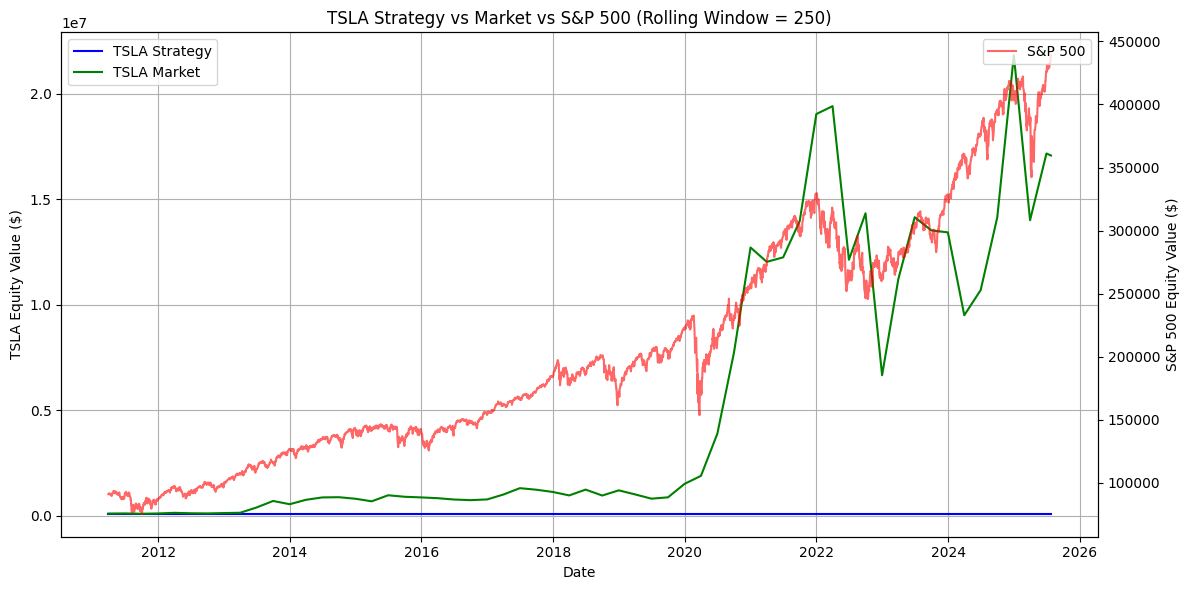

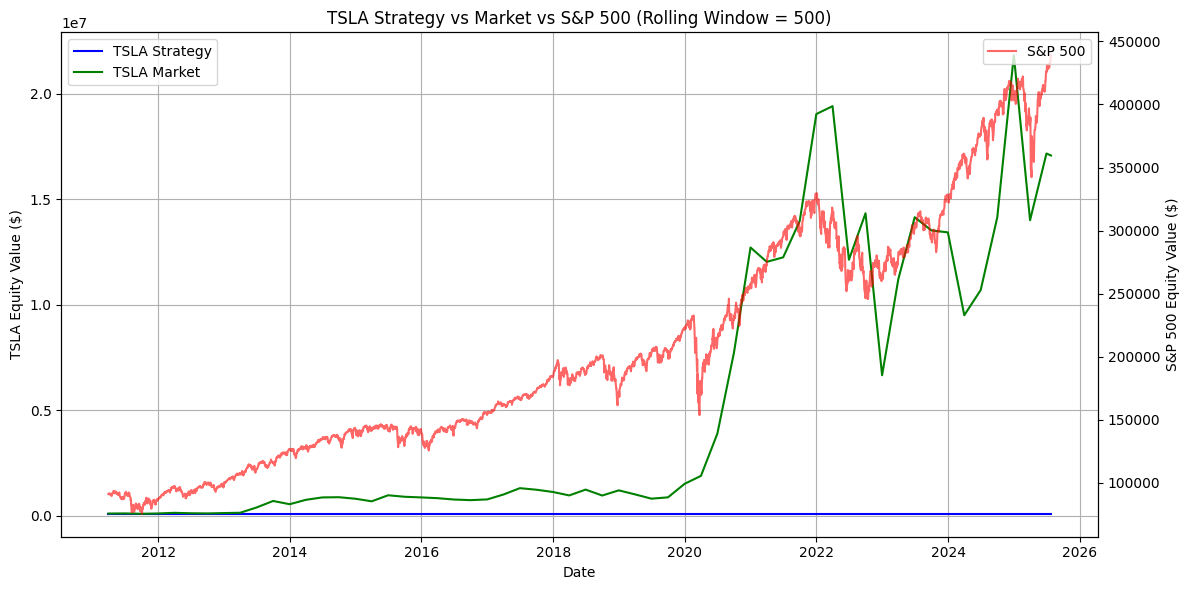

In [4]:
for ticker in tickers:
    for window in rolling_windows:
        temp = df[(df['TickerName'] == ticker) & (df['RollingWindow'] == window)].copy()
        temp = temp.sort_values('Date').reset_index(drop=True)

        temp['Return'] = temp['StockPrice'].pct_change().fillna(0)

        temp['Position'] = 0
        holding = False
        for i in range(1, len(temp)):
            if temp.loc[i-1, 'Signal'] == 1:
                holding = True
            elif temp.loc[i-1, 'Signal'] == -1:
                holding = False
            temp.loc[i, 'Position'] = 1 if holding else 0

        temp['Strategy_Return'] = temp['Return'] * temp['Position']
        temp['Cumulative_Strategy'] = (1 + temp['Strategy_Return']).cumprod()
        temp['Cumulative_Market'] = (1 + temp['Return']).cumprod()

        temp['Strategy_Equity'] = initial_capital * temp['Cumulative_Strategy']
        temp['Market_Equity'] = initial_capital * temp['Cumulative_Market']

        sp500_sub = sp500[(sp500['Date'] >= temp['Date'].min()) & (sp500['Date'] <= temp['Date'].max())].copy()
        sp500_sub = sp500_sub.reset_index(drop=True)

        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.plot(temp['Date'], temp['Strategy_Equity'], label=f'{ticker} Strategy', color='blue')
        ax1.plot(temp['Date'], temp['Market_Equity'], label=f'{ticker} Market', color='green')
        ax1.set_xlabel('Date')
        ax1.set_ylabel(f'{ticker} Equity Value ($)')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(sp500_sub['Date'], sp500_sub['SP500_Curve'], label='S&P 500', color='red', alpha=0.6)
        ax2.set_ylabel('S&P 500 Equity Value ($)')
        ax2.legend(loc='upper right')

        plt.title(f'{ticker} Strategy vs Market vs S&P 500 (Rolling Window = {window})')
        plt.tight_layout()
        plt.show()